In [ ]:
from torchvision import *
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import time
import copy
from IPython.display import display
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,5)
model = model.to(device)

class SplittedResNet50(nn.Module):
    def __init__(self, resnet50):
        super().__init__()
        self.cnn = nn.Sequential(*list(resnet50.children())[:-1])
        self.flatten = nn.Flatten()
        self.fc = resnet50.fc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        representation = self.flatten(self.cnn(x))
        output = self.fc(representation)
        return representation, output

splited_model = SplittedResNet50(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 39.7MB/s]


In [ ]:
class Simple_LSTM(nn.Module):
  def __init__(self,input_size,output_size,hidden_size,batch_first):
    super(Simple_LSTM,self).__init__()
    self.rnn = nn.LSTM(input_size,hidden_size,batch_first)
    self.output_layer = nn.Linear(hidden_size,output_size)

    nn.init.xavier_normal_(self.rnn.weight_ih_l0)
    nn.init.orthogonal_(self.rnn.weight_hh_l0)

  def forward(self,inputs):
    h,_ = self.rnn(inputs)
    output = self.output_layer(h[:,-1])

    return output

In [ ]:
import torch.nn.functional as F
from torch import linalg as LA

class CrossEntropyOSLoss(nn.Module):
    def __init__(self, regularization_param):
        super().__init__()
        self.Cross_Entropy_Loss = nn.CrossEntropyLoss()
        self.alpha = regularization_param

    def forward(self, output, representation, target):

        # 通常のクロスエントロピー誤差
        CEL_value = self.Cross_Entropy_Loss(output, target)

        # Orthogonal Sphere Regularization
        normalized_representation = F.normalize(representation, p = 2, dim = 1)
        OS_value = torch.add(
            torch.matmul(torch.t(normalized_representation), normalized_representation),
            torch.eye(normalized_representation.size()[1], device = device),
            alpha = -1
        )
        OS_value = self.alpha*LA.norm(OS_value, ord = "fro")

        return CEL_value + OS_value


alpha = 0.01
loss_function = CrossEntropyOSLoss(alpha)

In [ ]:
from google.colab import drive
drive.mount("./gdrive")

Mounted at ./gdrive


In [ ]:
data_transforms = {
    "train":transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "test":transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir = "./gdrive/My Drive/data/datasets_2024-09-20/"
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                  for x in ["train","test"]}

dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4)
                for x in ["train","test"]}
dataset_sizes = {x:len(image_datasets[x]) for x in ["train","test"]}
class_names = image_datasets["train"].classesGROVE - Smart IR ジェスチャーセンサ

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


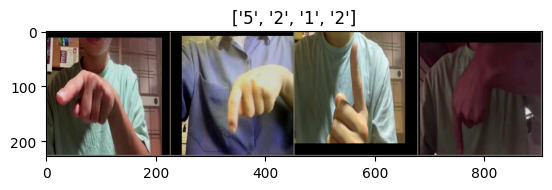

In [ ]:
def imshow(inp,title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = std * inp + mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs,classes = next(iter(dataloaders["train"]))
out = utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 各エポックには訓練フェーズと検証フェーズがあります
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに設定します
            else:
                model.eval()   # モードを評価するモデルを設定します

            running_loss = 0.0
            running_corrects = 0

            # データをイレテートします
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # パラメータの勾配をゼロにします
                optimizer.zero_grad()

                # 順伝播
                # 訓練の時だけ、履歴を保持します
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs[1], 1)
                    loss = criterion(outputs[1],outputs[0], labels)

                    # 訓練の時だけ逆伝播＋オプティマイズを行います
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 損失を計算します
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # モデルをディープ・コピーします
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # ベストモデルの重みをロードします
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs[1], 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torch.optim import lr_scheduler

optimizer_ft = optim.SGD(splited_model.parameters(),lr=0.001,momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(splited_model,loss_function,optimizer_ft,exp_lr_scheduler,num_epochs=30)

Epoch 0/29
----------
train Loss: 0.6668 Acc: 0.9281
test Loss: 0.4529 Acc: 1.0000

Epoch 1/29
----------
train Loss: 0.4797 Acc: 0.9928
test Loss: 0.4528 Acc: 1.0000

Epoch 2/29
----------
train Loss: 0.4863 Acc: 0.9914
test Loss: 0.4528 Acc: 1.0000

Epoch 3/29
----------
train Loss: 0.4785 Acc: 0.9932
test Loss: 0.4529 Acc: 1.0000

Epoch 4/29
----------
train Loss: 0.4727 Acc: 0.9937
test Loss: 0.4529 Acc: 1.0000

Epoch 5/29
----------
train Loss: 0.4607 Acc: 0.9980
test Loss: 0.4528 Acc: 1.0000

Epoch 6/29
----------
train Loss: 0.4577 Acc: 0.9986
test Loss: 0.4529 Acc: 1.0000

Epoch 7/29
----------
train Loss: 0.4578 Acc: 0.9989
test Loss: 0.4529 Acc: 1.0000

Epoch 8/29
----------
train Loss: 0.4570 Acc: 0.9993
test Loss: 0.4529 Acc: 1.0000

Epoch 9/29
----------
train Loss: 0.4585 Acc: 0.9987
test Loss: 0.4529 Acc: 1.0000

Epoch 10/29
----------
train Loss: 0.4561 Acc: 0.9996
test Loss: 0.4529 Acc: 1.0000

Epoch 11/29
----------
train Loss: 0.4548 Acc: 0.9998
test Loss: 0.4529 Acc

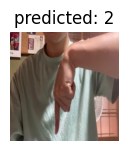

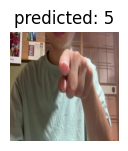

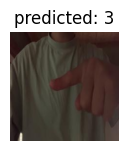

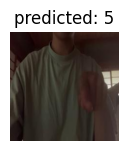

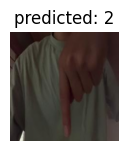

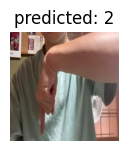

In [ ]:
visualize_model(model_ft)

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 102.0 MB/s eta 0:00:00


In [ ]:
torch.save(model_ft.state_dict(), './gdrive/My Drive/regularizedModel_weights_2024-09-27.pth')
import torch.onnx as onnx
input_image = torch.zeros((1,3,224,224)).to(device)
onnx.export(model_ft, input_image, './gdrive/My Drive/regularizedModel_2024-09-27.onnx')

モデルの構造確認

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

batch_size = 4
summary(model=model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [4, 5]                    --
├─Conv2d: 1-1                            [4, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [4, 64, 112, 112]         128
├─ReLU: 1-3                              [4, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [4, 64, 56, 56]           --
├─Sequential: 1-5                        [4, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [4, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [4, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [4, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [4, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [4, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [4, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [4, 64, 56, 56]           --
│ 